In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
def titanic_preprocessing(dataset):
    # Delete Cabin and PassengerId features because they don't add nothing to our model
    dataset = dataset.drop(['Cabin','PassengerId','Ticket'],axis=1)
    
    # Fill Age column with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    
    # Fill Embarked with most occuring values
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    
    # Fill Embarked with most occuring values
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
    
    return dataset

In [8]:
def titanic_feature_engineering(dataset):
    # Extract title from Name column
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(". ", expand=True)[0]
    rare_titles = dataset['Title'].value_counts()[:4].index.tolist()
    dataset.loc[~dataset['Title'].isin(rare_titles), 'Title'] = 'Rare'
    
#     # Fill Age column
#     grouped_dataset = dataset.iloc[:891].groupby(['Sex', 'Pclass', 'Title'])
#     grouped_median_dataset = grouped_dataset.median()
#     grouped_median_dataset = grouped_median_dataset.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
    
#     def fill_age(row):
#         condition = (
#             (grouped_median_dataset['Sex'] == row['Sex']) &
#             (grouped_median_dataset['Title'] == row['Title']) &
#             (grouped_median_dataset['Pclass'] == row['Pclass'])
#         )
#         return grouped_median_dataset[condition]['Age'].values[0]

#     def process_age(dataset):
#         dataset['Age'] = dataset.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
#         return dataset

#     dataset = process_age(dataset)
    
    # Bining
    dataset['Fare_cut'] = pd.qcut(dataset['Fare'], q=10)
    
    # Create dummy variables
    columns = ['Embarked', 'Title', 'Fare_cut']
    dummy = pd.get_dummies(dataset[columns], dtype=np.int32)
    dataset = pd.concat([dataset, dummy], axis=1)
    dataset['Sex_dummy'] = dataset['Sex'].map({'male': 0, 'female': 1})
    
    # Size of the family
    dataset['Family_size'] = dataset['SibSp'] + dataset['Parch']
    
    # Family size
    dataset['Marriage'] = 0
    dataset.loc[dataset['Family_size'] == 1, 'Marriage'] = 1
    
    dataset['S_family'] = 0
    dataset.loc[(dataset['Family_size'] <= 4) & (dataset['Family_size'] >= 2), 'S_family'] = 1
    
    dataset['B_family'] = 0
    dataset.loc[dataset['Family_size'] >= 5, 'B_family'] = 1
    
    dataset['IsAlone'] = 0
    dataset.loc[dataset['Family_size'] == 0, 'IsAlone'] = 1
    
    # Delete useless columns
    dataset = dataset.drop(['Name', 'Sex', 'Embarked', 'Fare_cut', 'Title'], axis=1)
    
    return dataset 

In [9]:
def model_evaluation(model):
    # Train our model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # F1-score
    f1 = f1_score(y_test, y_pred)
    print('F1-score: {}'.format(f1))
    
    
    # Confusion matrix
    print('Confusion Matrix: ')
    matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts =['{0:0.0f}'.format(value) for value in matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(matrix, annot=labels, fmt='', cmap='rocket_r')
    
    return f1

In [10]:
def dataset_preparation(dataset):
    dataset = titanic_preprocessing(dataset)
    dataset = titanic_feature_engineering(dataset)
    return dataset

In [11]:
data_train_prep = dataset_preparation(data_train)
data_test_prep = dataset_preparation(data_test)

In [12]:
data_train_prep

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Title_Master,...,"Fare_cut_(21.679, 27.0]","Fare_cut_(27.0, 39.688]","Fare_cut_(39.688, 77.958]","Fare_cut_(77.958, 512.329]",Sex_dummy,Family_size,Marriage,S_family,B_family,IsAlone
0,0,3,22.0,1,0,7.2500,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
1,1,1,38.0,1,0,71.2833,1,0,0,0,...,0,0,1,0,1,1,1,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1,0,...,0,0,1,0,1,1,1,0,0,0
4,0,3,35.0,0,0,8.0500,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
887,1,1,19.0,0,0,30.0000,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
888,0,3,28.0,1,2,23.4500,0,0,1,0,...,1,0,0,0,1,3,0,1,0,0
889,1,1,26.0,0,0,30.0000,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [13]:
data_test_prep

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,...,"Fare_cut_(21.196, 26.55]","Fare_cut_(26.55, 46.34]","Fare_cut_(46.34, 79.2]","Fare_cut_(79.2, 512.329]",Sex_dummy,Family_size,Marriage,S_family,B_family,IsAlone
0,3,34.5,0,0,7.8292,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,47.0,1,0,7.0000,0,0,1,0,0,...,0,0,0,0,1,1,1,0,0,0
2,2,62.0,0,0,9.6875,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,27.0,0,0,8.6625,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3,22.0,1,1,12.2875,0,0,1,0,0,...,0,0,0,0,1,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,27.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
414,1,39.0,0,0,108.9000,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
415,3,38.5,0,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
416,3,27.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
X = data_train_prep.drop(['Survived'], axis=1)
y = data_train_prep['Survived']

# Scalling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
data_test_scaled = scaler.fit_transform(data_test_prep)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
# K-nearest neighbors 
KNN_model = KNeighborsClassifier()

# SVC
SVC_model = SVC()

# Logistic regression
LR_model = LogisticRegression(max_iter=1000)

# Decision tree
DT_model = DecisionTreeClassifier()

# Random Forest
RF_model = RandomForestClassifier()

# Stochastic gradient descent
SGD_model = SGDClassifier()

# XGBoost
XGB_model = xgb.XGBClassifier(eta=0.01)

# LightGBM
LGBM_model = LGBMClassifier()

F1-score: 0.797752808988764
Confusion Matrix: 


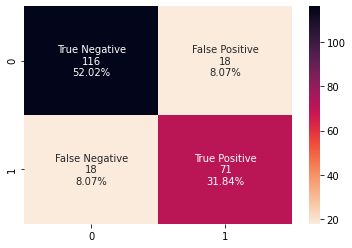

In [16]:
f1_for_KNN = model_evaluation(KNN_model)

F1-score: 0.7613636363636362
Confusion Matrix: 


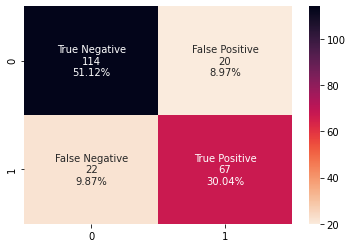

In [17]:
f1_for_SVC = model_evaluation(SVC_model)

F1-score: 0.7752808988764045
Confusion Matrix: 


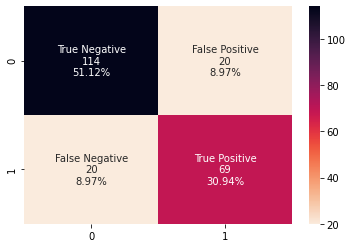

In [18]:
f1_for_LR = model_evaluation(LR_model)

F1-score: 0.7071823204419889
Confusion Matrix: 


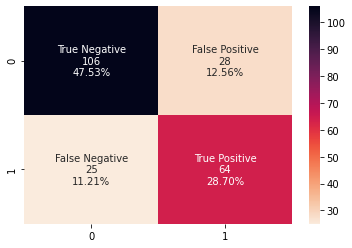

In [19]:
f1_for_DT = model_evaluation(DT_model)

F1-score: 0.7500000000000001
Confusion Matrix: 


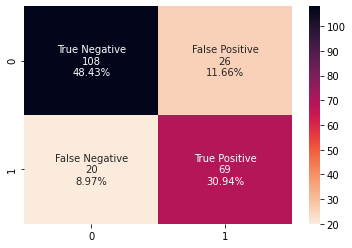

In [20]:
f1_for_RF = model_evaluation(RF_model)

F1-score: 0.7051282051282053
Confusion Matrix: 


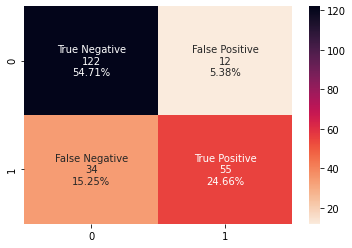

In [21]:
f1_for_SGD = model_evaluation(SGD_model)

F1-score: 0.7885714285714286
Confusion Matrix: 


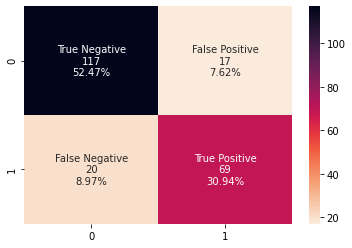

In [22]:
f1_for_XGB = model_evaluation(XGB_model)

F1-score: 0.782122905027933
Confusion Matrix: 


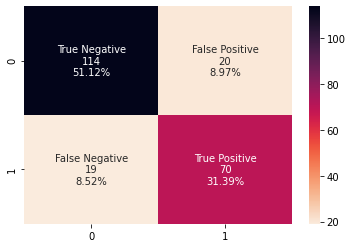

In [23]:
f1_for_LGBM = model_evaluation(LGBM_model)

In [24]:
XGB_model = xgb.XGBClassifier(
    reg_alpha = 0.1,
    learning_rate =0.01,
    n_estimators=1000,
    # eta = 0.01,
    gamma = 0,
    reg_lambda = 0.5,
    max_depth = 4,
    main_child_weight = 0.5,
    sampling_method = 'uniform',
    subsample=1,
)

eval_set = [(X_train, y_train), (X_test, y_test)]
model = XGB_model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True, early_stopping_rounds=10)

8
[93]	validation_0-error:0.142216	validation_0-logloss:0.437971	validation_1-error:0.147982	validation_1-logloss:0.463318
[94]	validation_0-error:0.142216	validation_0-logloss:0.436679	validation_1-error:0.147982	validation_1-logloss:0.462439
[95]	validation_0-error:0.142216	validation_0-logloss:0.435382	validation_1-error:0.147982	validation_1-logloss:0.461413
[96]	validation_0-error:0.142216	validation_0-logloss:0.434124	validation_1-error:0.147982	validation_1-logloss:0.460559
[97]	validation_0-error:0.142216	validation_0-logloss:0.432883	validation_1-error:0.147982	validation_1-logloss:0.459759
[98]	validation_0-error:0.139222	validation_0-logloss:0.431638	validation_1-error:0.143498	validation_1-logloss:0.458807
[99]	validation_0-error:0.139222	validation_0-logloss:0.430432	validation_1-error:0.143498	validation_1-logloss:0.457948
[100]	validation_0-error:0.139222	validation_0-logloss:0.429221	validation_1-error:0.143498	validation_1-logloss:0.457032
[101]	validation_0-error:0.13

Best Score for XGB: 0.7853876288287601 
With params: {'alpha': 0.5, 'eta': 0.05, 'gamma': 0, 'lambda': 0.5, 'max_depth': 4, 'min_child_weight': 0.5, 'sampling_method': 'uniform', 'subsample': 1}

In [25]:
parameters = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

# search = GridSearchCV(XGB_model, parameters, verbose=3, scoring='f1')
# search.fit(X_train, y_train)

In [26]:
# print('Best Score for XGB: {} \nWith params: {}'.format(search.best_score_, search.best_params_))

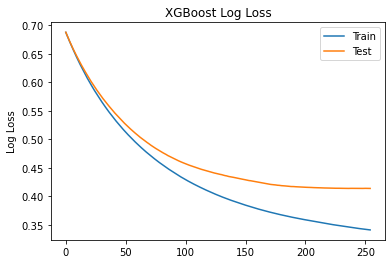

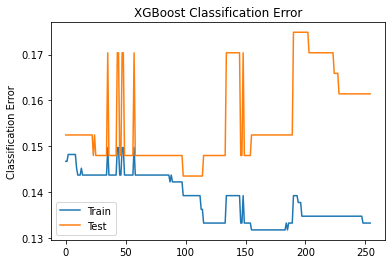

In [27]:
results = XGB_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [28]:
y_hat = XGB_model.predict(X_test)
f1_score(y_test, y_hat)

0.7882352941176471

In [29]:
y_pred = XGB_model.predict(data_test_scaled)

In [30]:
my_submission = pd.DataFrame({'PassengerId': data_test.PassengerId, 'Survived': y_pred})
my_submission.to_csv('submission_v8.csv', index=False)